## Selecting a deep learning model with MLP

Next step for our research is deep learning. For this stage we try using **MLP model** with keras. 

####  Import libraries,  import custom scripts and define constants  

In [27]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from sklearn.model_selection import train_test_split


import re

In [28]:
import os,sys,inspect
currentdir=os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir=os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
from src import preprocessing

In [29]:
#definition constants
RANDOM_STATE = 11
TARGET_METRIC = 'f1'
TEST_SIZE = 0.15


####  Loading the data

In [30]:
# import & display data
data = pd.read_csv('../../data/IMDB_Dataset.csv')
data['sentiment'] = data['sentiment'].replace({'positive' : 1, 'negative' : 0})
data = data.drop_duplicates()
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


####  Split data for training, testing and validation sets

In [31]:
X = data.review
y = data.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                    y_train,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify = y_train)

#### Preprocessing Data

For pre-processing and vectorization, let's use the approach from the previous stage, which received the best performance.

For pre-processing:
* the removal of html-tags,
* the separation of numbers and letters.  

For vectorization we use  `TfidfVectorizer(ngram_range=(1,2))`

In [32]:
MAX_FEATURES = 50000

vectorizer = TfidfVectorizer(ngram_range=(1,2), preprocessor=preprocessing.preprocessing_text, max_features=MAX_FEATURES)

vectorizer.fit(X_train)
X_train_features = vectorizer.transform(X_train)
X_valid_features = vectorizer.transform(X_valid)
X_test_features = vectorizer.transform(X_test)

#### Creating the model
Define the function for create the simple MLP model

In [18]:
def mlp_model(layers, units, dropout_rate, input_shape):
    model = Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))
    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [25]:
#function for f1 metric
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Define the function for training the model

In [25]:
def train_model(learning_rate=1e-4,
                epochs=1000,
                batch_size=128,
                layers=2,
                units=32,
                dropout_rate=0.3,
                filepath='model.hdf5'):
    
    # Create model instance.
    K.clear_session()
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=X_train_features.shape[1:])

    # Compile model with learning parameters.
    loss = 'binary_crossentropy'
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=[get_f1])

    # Create callback for early stopping on validation loss. 
    early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3)
    cp_callback = ModelCheckpoint(filepath=filepath,
                              save_best_only=True,
                              verbose=1)
    callbacks = [cp_callback, early_stop]
    
    model.summary()
    
    # Train and validate model.
    history = model.fit(
            X_train_features,
            y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(X_valid_features, y_valid),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    return history

### Train different models and save result

Result of exploring let's save to Dataframe

In [26]:
models_research_df = pd.DataFrame(columns=['Model',
                                           'loss',
                                           'f1_score',
                                           'val_loss',
                                           'val_f1'], )
results = {}

# add data to result research dataframe
def add_data_df(table_df_for_add, model_name, history_research):
    history_research = history_research.history
    index = history_research['val_loss'].index(min(history_research['val_loss']))
    model_research = (model_name, history_research['loss'][index], history_research['get_f1'][index], history_research['val_loss'][index], history_research['val_get_f1'][index])
    if any([list(row.values ) == list(model_research) for _, row in table_df_for_add.iterrows()]):
        return
    table_df_for_add.loc[len(table_df_for_add)] = model_research

In [27]:
models_research_df

,Model,loss,f1_score,val_loss,val_f1


Model1:  
* learning_rate=1e-4,
* epochs=1000,
* batch_size=128,
* layers=2,
* units=32,
* dropout_rate=0.3.


In [28]:
results['model_1'] = train_model(learning_rate=1e-4,
                                 epochs=1000,
                                 batch_size=128,
                                 layers=2,
                                 units=32,
                                 dropout_rate=0.3,
                                 filepath='model_1_5_11.hdf5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1600032   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,600,065
Trainable params: 1,600,065
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Instructions for updating:
U

Model2:  
* learning_rate=1e-4,
* epochs=1000,
* batch_size=128,
* layers=3,
* units=32,
* dropout_rate=0.3.


In [30]:
results['model_2'] = train_model(learning_rate=1e-4,
                                 epochs=1000,
                                 batch_size=128,
                                 layers=3,
                                 units=32,
                                 dropout_rate=0.3,
                                 filepath='model_2_5_11.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1600032   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,601,121
Trainable params: 1,601,121
Non-trainable params: 0
_________________________________________________________________


Model3:  
* learning_rate=1e-4,
* epochs=1000,
* batch_size=128,
* layers=4,
* units=32,
* dropout_rate=0.3.

In [31]:
results['model_3'] = train_model(learning_rate=1e-4,
                                 epochs=1000,
                                 batch_size=128,
                                 layers=4,
                                 units=32,
                                 dropout_rate=0.3,
                                 filepath='model_3_5_11.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1600032   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________

Model4:  
* learning_rate=1e-4,
* epochs=1000,
* batch_size=128,
* layers=2,
* units=64,
* dropout_rate=0.3.

In [32]:
results['model_4'] = train_model(learning_rate=1e-4,
                                 epochs=1000,
                                 batch_size=128,
                                 layers=2,
                                 units=64,
                                 dropout_rate=0.3,
                                 filepath='model_4_5_11.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3200064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,200,129
Trainable params: 3,200,129
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.61098, saving model to model_4_5_11.hdf5
 - 40s - loss: 0.6570 - get_f1: 0.8097 - val_loss: 0.6110 - val_get_f1: 0.8745
Epoch 2/1000

Epoch 00002: val_loss 

Model5:  
* learning_rate=1e-4,
* epochs=1000,
* batch_size=128,
* layers=3,
* units=64,
* dropout_rate=0.3.

In [33]:
results['model_5'] = train_model(learning_rate=1e-4,
                                 epochs=1000,
                                 batch_size=128,
                                 layers=3,
                                 units=64,
                                 dropout_rate=0.3,
                                 filepath='model_5_5_11.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3200064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 3,204,289
Trainable params: 3,204,289
Non-trainable params: 0
_________________________________________________________________


Model6:  
* learning_rate=1e-4,
* epochs=1000,
* batch_size=128,
* layers=4,
* units=64,
* dropout_rate=0.3.

In [35]:
results['model_6'] = train_model(learning_rate=1e-4,
                                 epochs=1000,
                                 batch_size=128,
                                 layers=4,
                                 units=64,
                                 dropout_rate=0.3,
                                 filepath='model_6_5_11.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3200064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

Model7:  
* learning_rate=1e-3,
* epochs=1000,
* batch_size=128,
* layers=2,
* units=32,
* dropout_rate=0.3.

In [36]:
results['model_7'] = train_model(learning_rate=1e-3,
                                 epochs=1000,
                                 batch_size=128,
                                 layers=2,
                                 units=32,
                                 dropout_rate=0.3,
                                 filepath='model_7_5_11.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1600032   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,600,065
Trainable params: 1,600,065
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.29265, saving model to model_7_5_11.hdf5
 - 36s - loss: 0.4718 - get_f1: 0.8490 - val_loss: 0.2926 - val_get_f1: 0.9111
Epoch 2/1000

Epoch 00002: val_loss 

Model8:  
* learning_rate=1e-3,
* epochs=1000,
* batch_size=128,
* layers=3,
* units=32,
* dropout_rate=0.3.

In [37]:
results['model_8'] = train_model(learning_rate=1e-3,
                                 epochs=1000,
                                 batch_size=128,
                                 layers=3,
                                 units=32,
                                 dropout_rate=0.3,
                                 filepath='model_8_5_11.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1600032   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,601,121
Trainable params: 1,601,121
Non-trainable params: 0
_________________________________________________________________


Model9:  
* learning_rate=1e-3,
* epochs=1000,
* batch_size=128,
* layers=4,
* units=32,
* dropout_rate=0.3.

In [38]:
results['model_9'] = train_model(learning_rate=1e-3,
                                 epochs=1000,
                                 batch_size=128,
                                 layers=3,
                                 units=32,
                                 dropout_rate=0.3,
                                 filepath='model_9_5_11.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1600032   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,601,121
Trainable params: 1,601,121
Non-trainable params: 0
_________________________________________________________________


Model10:  
* learning_rate=1e-3,
* epochs=1000,
* batch_size=128,
* layers=2,
* units=64,
* dropout_rate=0.3.

In [39]:
results['model_10'] = train_model(learning_rate=1e-3,
                                 epochs=1000,
                                 batch_size=128,
                                 layers=2,
                                 units=64,
                                 dropout_rate=0.3,
                                 filepath='model_10_5_11.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3200064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,200,129
Trainable params: 3,200,129
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.24819, saving model to model_10_5_11.hdf5
 - 43s - loss: 0.4210 - get_f1: 0.8325 - val_loss: 0.2482 - val_get_f1: 0.9174
Epoch 2/1000

Epoch 00002: val_loss

Model11:  
* learning_rate=1e-3,
* epochs=1000,
* batch_size=128,
* layers=3,
* units=64,
* dropout_rate=0.3.

In [40]:
results['model_11'] = train_model(learning_rate=1e-3,
                                 epochs=1000,
                                 batch_size=128,
                                 layers=3,
                                 units=64,
                                 dropout_rate=0.3,
                                 filepath='model_11_5_11.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3200064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 3,204,289
Trainable params: 3,204,289
Non-trainable params: 0
_________________________________________________________________


Model12:  
* learning_rate=1e-3,
* epochs=1000,
* batch_size=128,
* layers=4,
* units=64,
* dropout_rate=0.3.

In [41]:
results['model_12'] = train_model(learning_rate=1e-3,
                                 epochs=1000,
                                 batch_size=128,
                                 layers=4,
                                 units=64,
                                 dropout_rate=0.3,
                                 filepath='model_12_5_11.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3200064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

Model13:  
* learning_rate=1e-4,
* epochs=1000,
* batch_size=128,
* layers=3,
* units=32,
* dropout_rate=0.6.

In [48]:
results['model_13'] = train_model(learning_rate=1e-4,
                                 epochs=1000,
                                 batch_size=128,
                                 layers=3,
                                 units=32,
                                 dropout_rate=0.6,
                                 filepath='model_13_5_11.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1600032   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,601,121
Trainable params: 1,601,121
Non-trainable params: 0
_________________________________________________________________


In [50]:
for result in results:
    add_data_df(models_research_df, result, results.get(result))

### The result of exploring

In [51]:
models_research_df

,Model,loss,f1_score,val_loss,val_f1
0,model_1,0.092952,0.973858,0.192373,0.925582
1,model_2,0.121765,0.961946,0.191669,0.925164
2,model_3,0.154522,0.950511,0.196144,0.924864
3,model_4,0.094697,0.972876,0.192576,0.927833
4,model_5,0.120957,0.960728,0.194082,0.927148
5,model_6,0.150207,0.949292,0.195007,0.924077
6,model_7,0.127915,0.958873,0.197223,0.921729
7,model_8,0.179523,0.935325,0.204714,0.918080
8,model_9,0.175817,0.934947,0.203161,0.920587
9,model_10,0.136252,0.953478,0.198652,0.924451


### Select the best model

Let's coose the best model the model_13:
The model with **3** the hidden layer - **Dense(32)** and one the **Dropout** layers with `rate=0.6`.
For train the models use **Adam** optimazer with `learning_rate=1e-4`


In [33]:
best_mpl_model = tf.keras.models.load_model('model_13_5_11.hdf5',  custom_objects={'get_f1': get_f1})
best_mpl_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1600032   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,601,121
Tra

In [34]:
loss, f1_score = best_mpl_model.evaluate(X_test_features,  y_test, verbose=2)
print("F1 score with the best MLP model for test dataset: {:5.2f}%".format(100*f1_score))

 - 4s - loss: 0.2155 - get_f1: 0.9125
F1 score with the best MLP model for test dataset: 91.25%


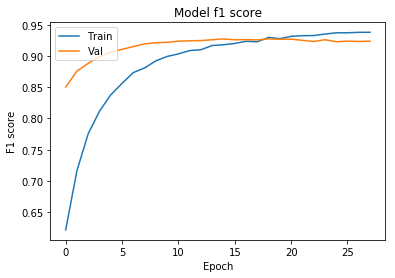

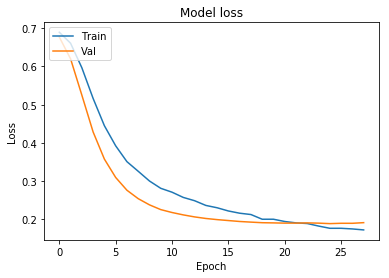

In [61]:
# plt.plot(history.history['f1_score'])
plt.plot(results['model_13'].history['get_f1'])
plt.plot(results['model_13'].history['val_get_f1'])
plt.title('Model f1 score')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(results['model_13'].history['loss'])
plt.plot(results['model_13'].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()